In [19]:
import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


def load_images_with_contours(folder_path, target_size=(256, 256), contour_thickness=2):
    images = []
    labels = []
    label_map = {}  # Mapping from label names to integer indices

    # Iterating through the subfolders (categories) in the dataset folder
    for i, category in enumerate(sorted(os.listdir(folder_path))):
        label_map[i] = category
        category_path = os.path.join(folder_path, category)

        # Iterate through the image files in each category folder
        for filename in os.listdir(category_path):
            img_path = os.path.join(category_path, filename)
            
            # Load the image using OpenCV
            img = cv2.imread(img_path)  

            # Converting BGR to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

            # Resizing the image
            resized_img = cv2.resize(img, target_size) 

            # Grayscale Conversion
            gray_img = cv2.cvtColor(resized_img, cv2.COLOR_RGB2GRAY)  

            # Image Segmentation
            _, binary_img = cv2.threshold(gray_img, 127, 255, cv2.THRESH_BINARY)  # Convert to binary image

            # Finding contours
            contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  
            img_with_contours = cv2.drawContours(resized_img.copy(), contours, -1, (0, 255, 0), contour_thickness)  # Draw contours

            # Converting back to BGR
            img_with_contours = cv2.cvtColor(img_with_contours, cv2.COLOR_RGB2BGR) 
            images.append(img_with_contours)
            labels.append(i)

    images = np.array(images)
    labels = np.array(labels)

    return images, labels, label_map

# Example usage:
folder_path = "C:/Users/USER/OneDrive/Desktop/Tracy/School/Sem 2/Big Data/Assignments/2/Data/Leaf_dataset/"
images_with_contours, labels_with_contours, label_map_with_contours = load_images_with_contours(folder_path)


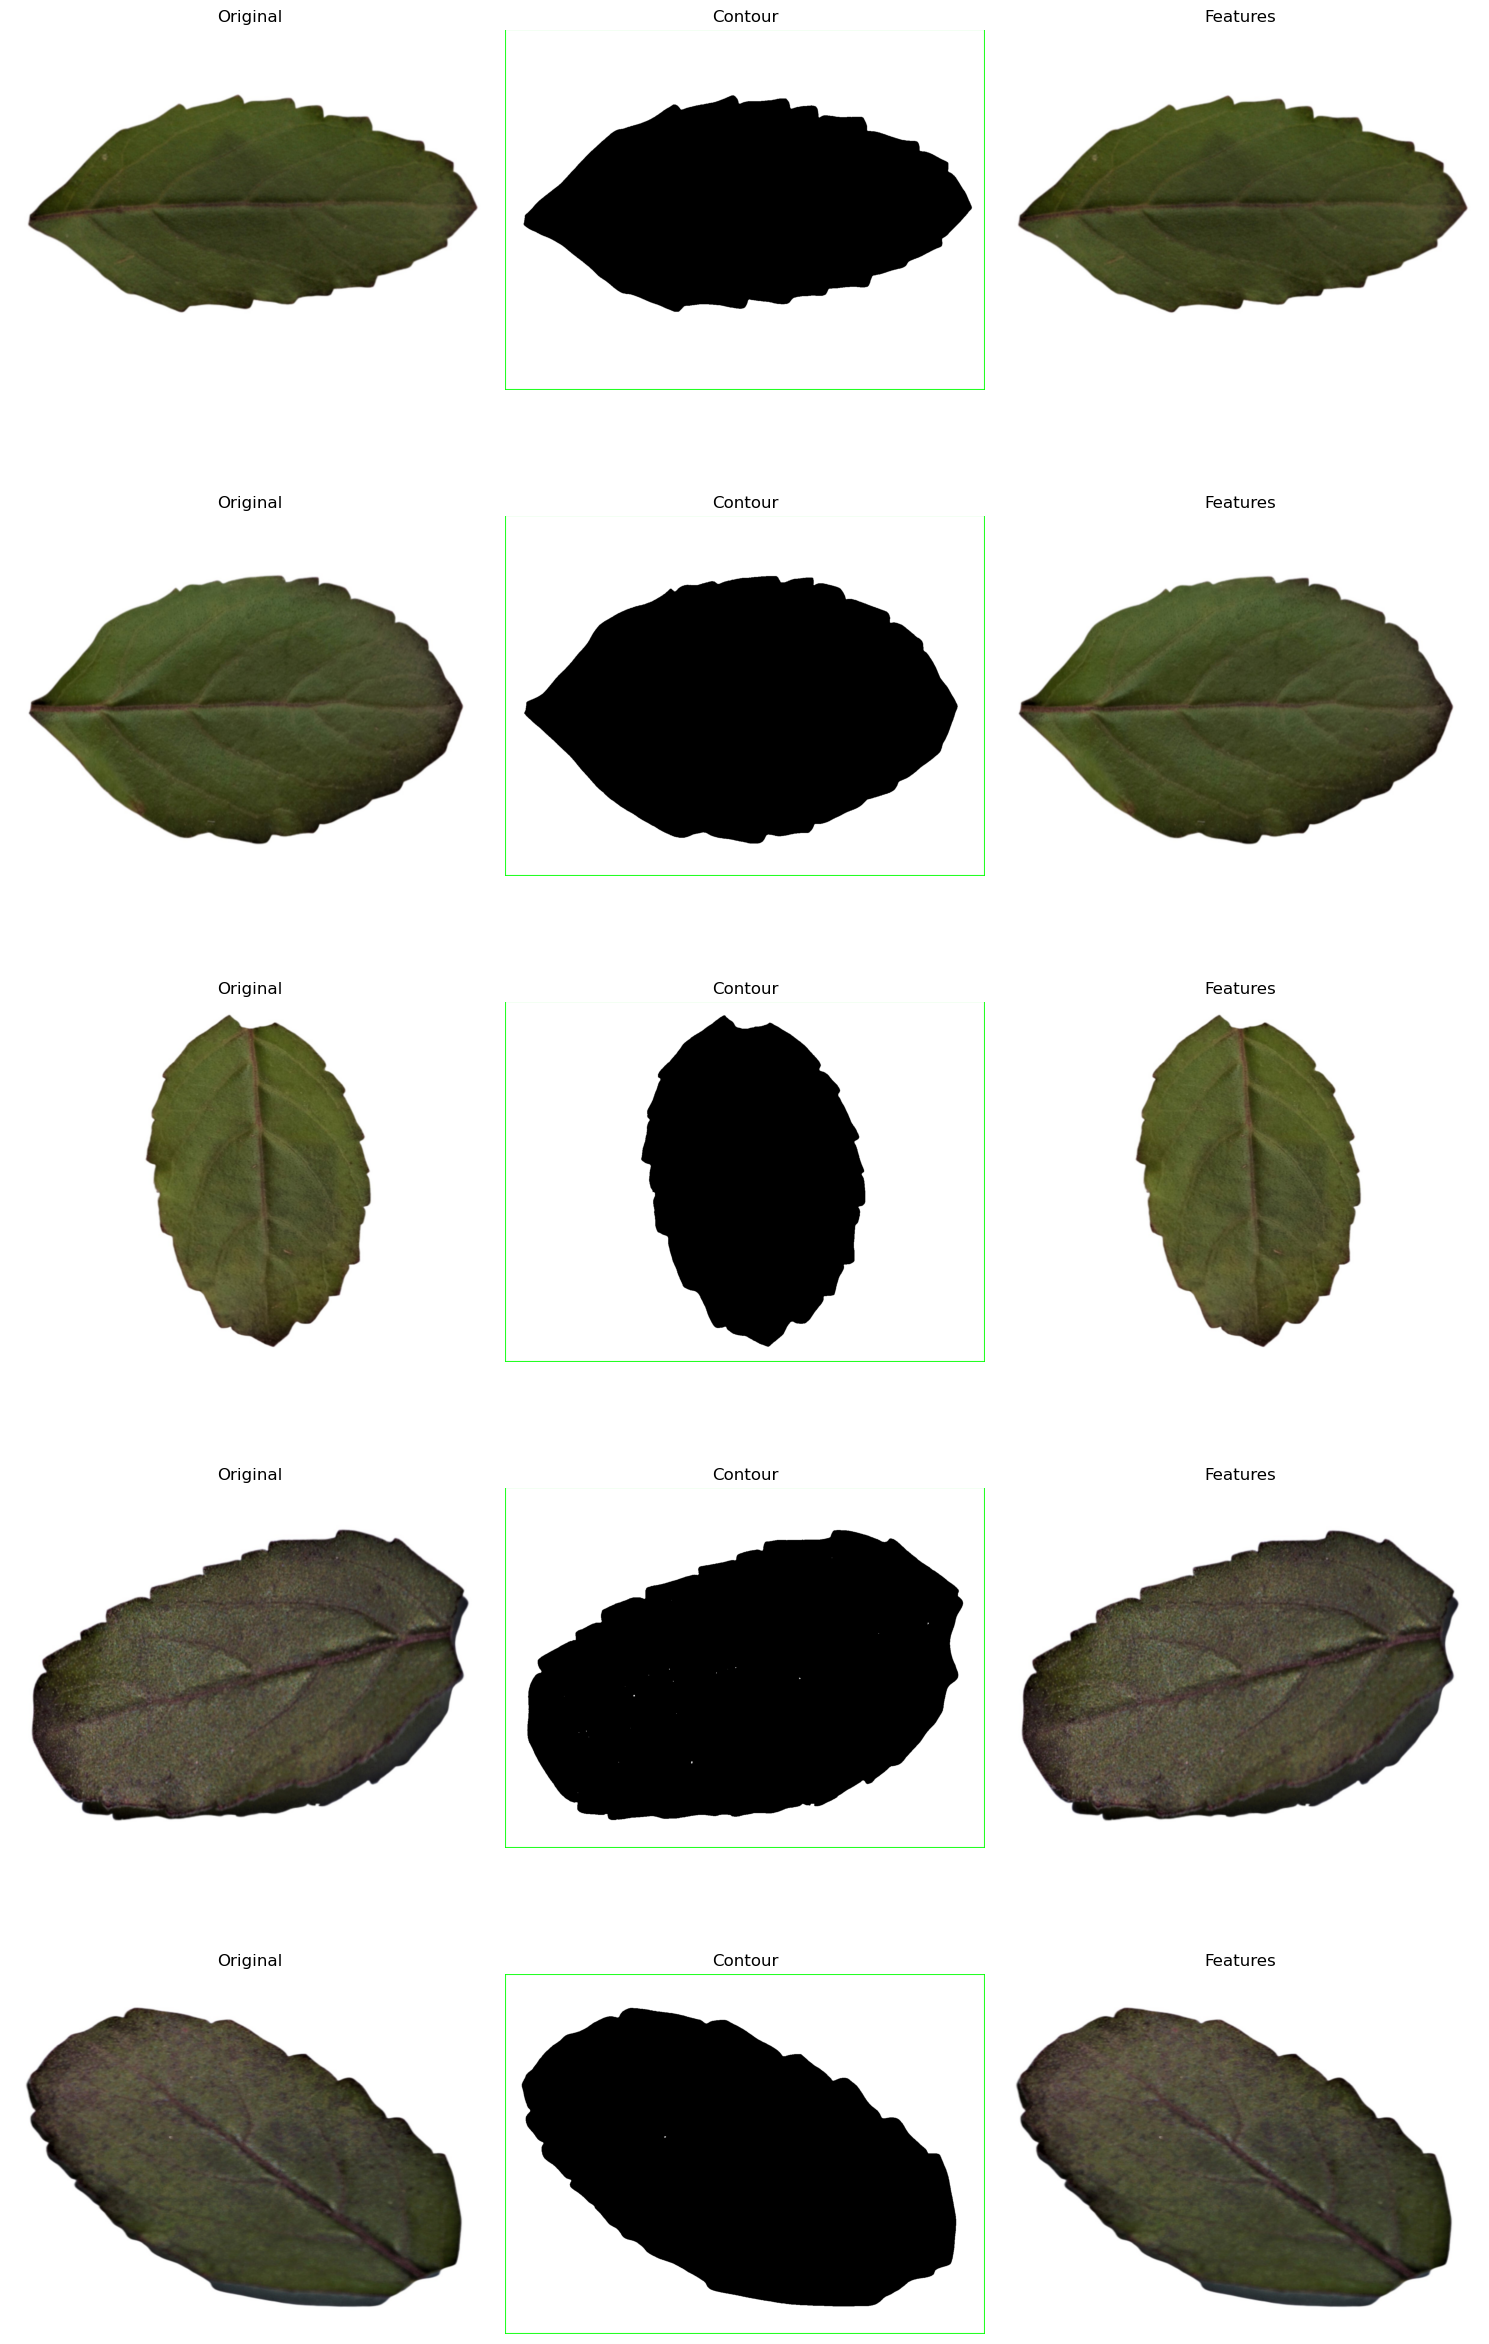

In [21]:
import matplotlib.pyplot as plt

def extract_features_from_contour(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, thresh_img = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Creating an empty mask
    mask = np.zeros_like(gray)
    
    # Drawing contours on the mask
    cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)
    
    # Applying the mask to the original image
    masked_img = cv2.bitwise_and(img, img, mask=mask)
    
    return masked_img

def display_images_with_contour_and_feature(folder_path, num_images=5):
    fig, axes = plt.subplots(nrows=num_images, ncols=3, figsize=(15, 5*num_images))
    
    # Get a list of image files in the folder
    image_files = [file for file in os.listdir(folder_path) if file.endswith(('.jpg', '.jpeg', '.png'))][:num_images]
    
    for i, image_file in enumerate(image_files):
        img_path = os.path.join(folder_path, image_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Original image
        axes[i, 0].imshow(img)
        axes[i, 0].axis('off')
        axes[i, 0].set_title('Original')
        
        # Extract contour
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        _, thresh_img = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contour_img = cv2.drawContours(cv2.cvtColor(thresh_img, cv2.COLOR_GRAY2RGB), contours, -1, (0, 255, 0), 3)
        axes[i, 1].imshow(contour_img)
        axes[i, 1].axis('off')
        axes[i, 1].set_title('Contour')
        
        # Extracted features from contour
        feature_img = extract_features_from_contour(img)
        axes[i, 2].imshow(feature_img)
        axes[i, 2].axis('off')
        axes[i, 2].set_title('Features')
    
    plt.tight_layout()
    plt.show()

# Example usage:
folder_path = "C:/Users/USER/OneDrive/Desktop/Tracy/School/Sem 2/Big Data/Assignments/2/Data/Leaf_dataset/Ocimum Tenuiflorum (Tulsi)"
display_images_with_contour_and_feature(folder_path)


In [22]:
def extract_color_histogram(img):
    # Convert the image to the HSV color space
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    # Calculate the color histogram
    hist_hue = cv2.calcHist([hsv_img], [0], None, [256], [0, 256])
    hist_saturation = cv2.calcHist([hsv_img], [1], None, [256], [0, 256])
    hist_value = cv2.calcHist([hsv_img], [2], None, [256], [0, 256])
    
    # Normalize the histograms
    hist_hue /= np.sum(hist_hue)
    hist_saturation /= np.sum(hist_saturation)
    hist_value /= np.sum(hist_value)
    
    # Concatenate the histograms into a single feature vector
    color_histogram = np.concatenate((hist_hue, hist_saturation, hist_value)).flatten()
    
    return color_histogram

def extract_features_from_contour(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, thresh_img = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create an empty mask
    mask = np.zeros_like(gray)
    
    # Draw contours on the mask
    cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)
    
    # Apply the mask to the original image
    masked_img = cv2.bitwise_and(img, img, mask=mask)
    
    return masked_img

def create_feature_matrix(folder_path):
    feature_matrix = []
    
    for category in os.listdir(folder_path):
        category_path = os.path.join(folder_path, category)
        for image_file in os.listdir(category_path):
            img_path = os.path.join(category_path, image_file)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Extract features from contour
            feature_img = extract_features_from_contour(img)
            
            # Extract color histogram features
            color_histogram = extract_color_histogram(feature_img)
            
            # Append the features to the feature matrix
            feature_matrix.append(color_histogram)
    
    return np.array(feature_matrix)

# Example usage:
folder_path = "C:/Users/USER/OneDrive/Desktop/Tracy/School/Sem 2/Big Data/Assignments/2/Data/Leaf_dataset/"
feature_matrix = create_feature_matrix(folder_path)
print("Shape of feature matrix:", feature_matrix.shape)


Shape of feature matrix: (270, 768)


In [23]:
X=feature_matrix
y= labels_with_contours

In [40]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

# Define the number of folds for cross-validation
num_folds = 10

# Initialize StratifiedKFold for cross-validation
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)



# Perform cross-validation for each classifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grids for each classifier
svm_param_grid = {'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10]}
knn_param_grid = {'n_neighbors': [3, 5, 7, 9]}
rf_param_grid = {'n_estimators': [100, 200, 300]}

# Initialize classifiers with default parameters
classifiers = {
    'SVM': SVC(),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier()
}

# Hyperparameter grids for each classifier
param_grids = {
    'SVM': svm_param_grid,
    'KNN': knn_param_grid,
    'Random Forest': rf_param_grid
}

# Perform cross-validation for each classifier with hyperparameter tuning
from sklearn.metrics import classification_report

for clf_name, clf in classifiers.items():
    scores = []
    for train_idx, test_idx in kfold.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Initialize GridSearchCV for hyperparameter tuning
        grid_search = GridSearchCV(clf, param_grids[clf_name], cv=5, n_jobs=-1)
        
        # Fit the model with GridSearchCV
        grid_search.fit(X_train, y_train)
        
        # Get the best estimator
        best_clf = grid_search.best_estimator_
        
        # Evaluate the classifier
        accuracy = best_clf.score(X_test, y_test)
        scores.append(accuracy)

    # Calculate and print the mean accuracy for each classifier
    mean_accuracy = np.mean(scores)
    print(f"Mean Accuracy for {clf_name}: {mean_accuracy}")
    
 # Generate classification report for the current classifier
    report = classification_report(y_test, predictions, target_names=target_names)
    
    # Print the classification report
    print(f"Classification Report for {clf_name}:")
    print(report)
 

Mean Accuracy for SVM: 0.9851851851851852
Classification Report for SVM:
              precision    recall  f1-score   support

        Mint       1.00      1.00      1.00         9
       Tulsi       1.00      1.00      1.00         5
       Guava       1.00      1.00      1.00         7
  Rose Apple       1.00      1.00      1.00         6

    accuracy                           1.00        27
   macro avg       1.00      1.00      1.00        27
weighted avg       1.00      1.00      1.00        27

Mean Accuracy for KNN: 0.951851851851852
Classification Report for KNN:
              precision    recall  f1-score   support

        Mint       1.00      1.00      1.00         9
       Tulsi       1.00      1.00      1.00         5
       Guava       1.00      1.00      1.00         7
  Rose Apple       1.00      1.00      1.00         6

    accuracy                           1.00        27
   macro avg       1.00      1.00      1.00        27
weighted avg       1.00      1.00      1

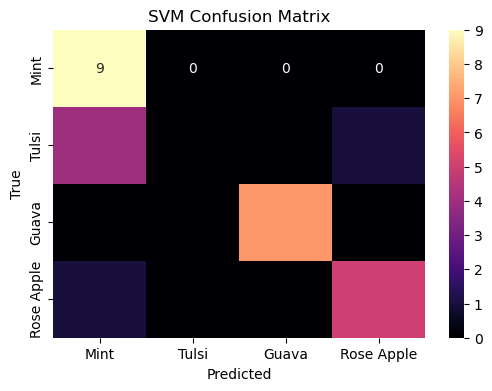

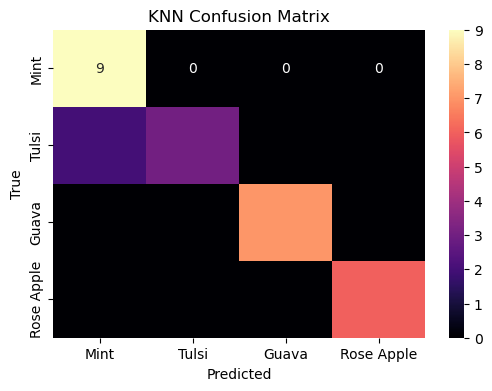

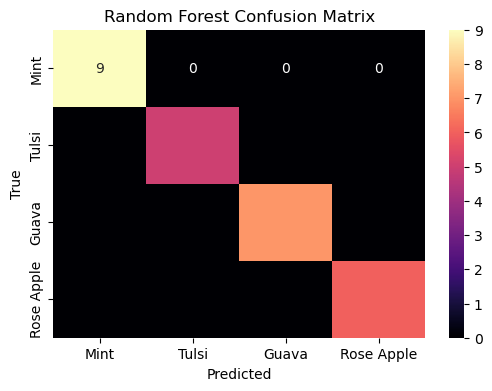

Classification Report:
              precision    recall  f1-score   support

        Mint       1.00      1.00      1.00         9
       Tulsi       1.00      1.00      1.00         5
       Guava       1.00      1.00      1.00         7
  Rose Apple       1.00      1.00      1.00         6

    accuracy                           1.00        27
   macro avg       1.00      1.00      1.00        27
weighted avg       1.00      1.00      1.00        27



In [29]:
# Evaluation and visualization of confusion matrices
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Define the class names
target_names = ['Mint', 'Tulsi', 'Guava', 'Rose Apple']


# Loop through each trained model
for clf_name, clf in classifiers.items():

    # Fit the classifier with training data
    clf.fit(X_train, y_train)
    
    # Make predictions using the trained model
    predictions = clf.predict(X_test)  # Assuming X_test_flat is defined
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, predictions)
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='magma', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{clf_name} Confusion Matrix')
    plt.show()

# Assuming you have predictions and ground truth labels for your test data
#predictions = clf.predict(X_test)
#y_test = ground truth labels

# Generate classification report
report = classification_report(y_test, predictions, target_names=target_names)

# Print the classification report
print("Classification Report:")
print(report)

In [31]:
from sklearn.model_selection import cross_val_score

# Assuming clf is your classifier
# Calculate cross-validated scores
cv_scores = cross_val_score(clf, X, y, cv=10)

# Print mean cross-validated accuracy
print("Mean Cross-Validated Accuracy:", cv_scores.mean())

Mean Cross-Validated Accuracy: 0.9703703703703704


In [26]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
import warnings
warnings.filterwarnings("ignore")


# Load and preprocess dataset
def load_dataset(path):
    images = []
    labels = []
    target_names = os.listdir(path)
    for label, target_name in enumerate(target_names):
        label_dir = os.path.join(path, target_name)
        for filename in os.listdir(label_dir):
            filepath = os.path.join(label_dir, filename)
            img = cv2.imread(filepath)
            if img is not None:
                img = cv2.resize(img, (128, 128))
                images.append(img)
                labels.append(label)
            else:
                print(f"Warning: Unable to read image {filepath}")
    return images, labels, target_names



train_dir = "C:/Users/USER/OneDrive/Desktop/Tracy/School/Sem 2/Big Data/Assignments/2/Data/Leaf_dataset/"
images, labels, target_names = load_dataset(train_dir)

# Convert images and labels to numpy arrays for easier manipulation
images = np.array(images, dtype=np.float32) / 255.0  # Normalize images
original_labels = np.array(labels)  # Keep original labels for StratifiedKFold
num_classes = len(np.unique(original_labels))

# Define model functions
def create_fcnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Flatten(input_shape=input_shape),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def create_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

    # Hyperparameter grids for FCNN
fcnn_param_grid = {
    'dense_units': [256, 512, 1024],
    'dropout_rate': [0.3, 0.5, 0.7]
}

# Hyperparameter grids for CNN
cnn_param_grid = {
    'filters': [(32, 64, 128), (64, 128, 256)],
    'kernel_sizes': [((3, 3), (3, 3), (3, 3)), ((5, 5), (5, 5), (5, 5))],
    'dropout_rate': [0.3, 0.5, 0.7]
}

# Evaluate and visualize model performance
def evaluate_models(model_fn, data, original_labels, num_classes, num_folds=10):
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    fold_metrics = []
    for fold, (train_idx, test_idx) in enumerate(skf.split(data, original_labels)):
        print(f"Training fold {fold+1}/{num_folds}")
        labels = to_categorical(original_labels, num_classes)
        model = model_fn(data.shape[1:], num_classes)
        model.fit(data[train_idx], labels[train_idx], batch_size=32, epochs=10, verbose=0,
                  validation_data=(data[test_idx], labels[test_idx]))
        scores = model.evaluate(data[test_idx], labels[test_idx], verbose=0)
        predictions = model.predict(data[test_idx])
        y_pred = np.argmax(predictions, axis=1)
        y_true = original_labels[test_idx]
        cm = confusion_matrix(y_true, y_pred)
        report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
        fold_metrics.append({'acc': scores[1], 'loss': scores[0], 'cm': cm, 'report': report})
        print(f"Fold {fold+1} Accuracy: {scores[1]}")
    average_accuracy = np.mean([fm['acc'] for fm in fold_metrics])
    print(f"Averaged Accuracy for {model_fn.__name__}: {average_accuracy}")
    return fold_metrics

# Running evaluations
fcnn_metrics = evaluate_models(create_fcnn, images, original_labels, num_classes)
cnn_metrics = evaluate_models(create_cnn, images, original_labels, num_classes)



Training fold 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Fold 1 Accuracy: 0.8888888955116272
Training fold 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Fold 2 Accuracy: 1.0
Training fold 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Fold 3 Accuracy: 0.8888888955116272
Training fold 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Fold 4 Accuracy: 0.9629629850387573
Training fold 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Fold 5 Accuracy: 0.8888888955116272
Training fold 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Fold 6 Accuracy: 0.9629629850387573
Training fold 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Fold 7 Accuracy: 1.0
Training fold 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Fold 8 Accuracy: 0.9629629850387573
Training fold 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Fold 9 Accuracy: 1.0
Training fold 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Fold 10 Accuracy: 0.8888888955116272
Averaged Accuracy for create_fcnn: 0.944444453716278
Training fold 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Fully Connected Neural Network (FCNN) Performance:
Average Accuracy: 0.9074
Average Loss: 0.2488
Average Precision: 0.9213
Average Recall: 0.8933
Average F1 Score: 0.8905


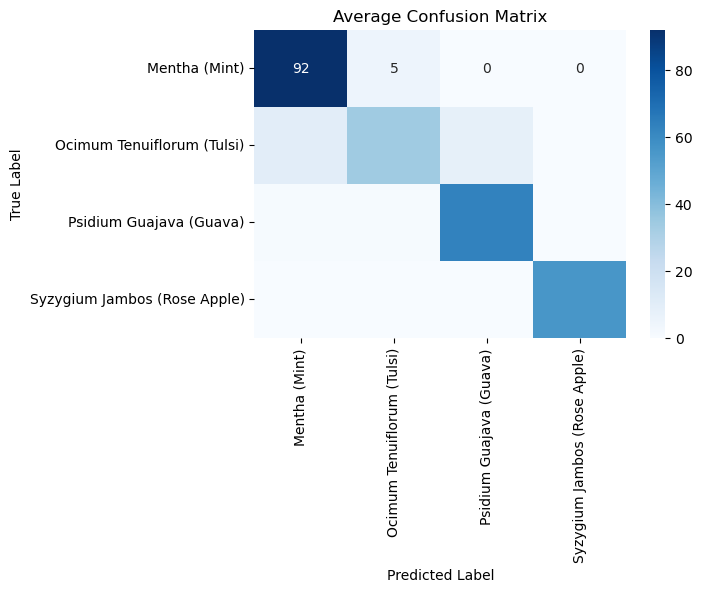

Convolutional Neural Network (CNN) Performance:
Average Accuracy: 0.9704
Average Loss: 0.0537
Average Precision: 0.9749
Average Recall: 0.9664
Average F1 Score: 0.9665


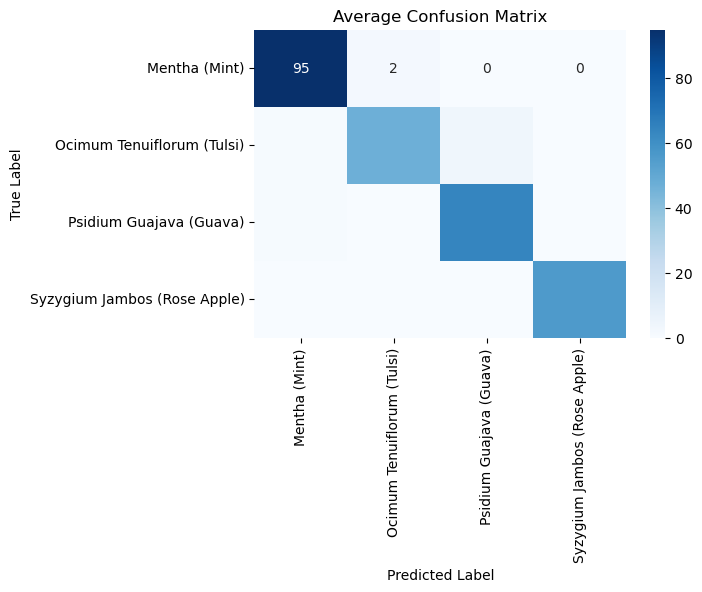

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names, title='Confusion Matrix'):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Function to print and plot evaluation metrics
def evaluate_performance(metrics, target_names):
    accuracies = [m['acc'] for m in metrics]
    losses = [m['loss'] for m in metrics]
    precision = np.mean([m['report']['macro avg']['precision'] for m in metrics])
    recall = np.mean([m['report']['macro avg']['recall'] for m in metrics])
    f1 = np.mean([m['report']['macro avg']['f1-score'] for m in metrics])

    print(f"Average Accuracy: {np.mean(accuracies):.4f}")
    print(f"Average Loss: {np.mean(losses):.4f}")
    print(f"Average Precision: {precision:.4f}")
    print(f"Average Recall: {recall:.4f}")
    print(f"Average F1 Score: {f1:.4f}")

    # Average confusion matrix
    summed_cm = np.sum([m['cm'] for m in metrics], axis=0)
    plot_confusion_matrix(summed_cm, target_names, title='Average Confusion Matrix')
# Evaluating and plotting for FCNN
print("Fully Connected Neural Network (FCNN) Performance:")
evaluate_performance(fcnn_metrics, target_names)

# Evaluating and plotting for CNN
print("Convolutional Neural Network (CNN) Performance:")
evaluate_performance(cnn_metrics, target_names)


In [33]:
import pandas as pd

# Define classifiers and their mean average scores
classifiers = ['SVM', 'KNN', 'Random Forest', 'CNN', 'FCNN']
mean_scores = [0.985, 0.952, 0.978, 0.889, 0.944]  # Replace these values with your actual mean average scores for CNN and FCNN

# Create a DataFrame
data = {'Classifier': classifiers, 'Mean Average Score': mean_scores}
df = pd.DataFrame(data)

# Display the DataFrame
print(df)


      Classifier  Mean Average Score
0            SVM               0.985
1            KNN               0.952
2  Random Forest               0.978
3            CNN               0.889
4           FCNN               0.944
